In [ ]:
#|default_exp hotmax

# Hotmax spectra 

> Cherry picking the best spectra

In [ ]:
#|hide 
from maxrf4u import tree

In [ ]:
#|hide 
import os

In [ ]:
#|hide 
os.chdir('/home/frank/Work/DATA/maxrf4u-data/')
os.listdir()

['RP-T-1898-A-3689.raw',
 'RP-T-1898-A-3689.rpl',
 'RP-T-1898-A-3689.datastack_backup',
 'RP-T-1898-A-3689_FeKa-map-clipped.png',
 'RP-T-1898-A-3689.datastack',
 'RP-T-1898-A-3689_highres.png']

In [ ]:
#|hide 
tree('RP-T-1898-A-3689.datastack')

RP-T-1898-A-3689.datastack:

/
 ├── compton_peak_energy (1,) float64
 ├── imvis_extent (4,) int64
 ├── imvis_reg (1692, 1592, 4) float32
 ├── imvis_reg_highres (4920, 4629, 4) float32
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_energies (4096,) float64
 ├── maxrf_maxspectrum (4096,) float32
 ├── maxrf_sumspectrum (4096,) float64
 └── test_list (3, 3) int64


A MA-XRF spectral image data cube contains typically a million spectra or so. Far too many to analyze them individually! Furthermore, most of these spectra have low signals and are rather noisy. An approach to overcome these computational problems is to base a further data analysis solely on the max spectrum. Such an approach is used e.g. by [DataMuncher](https://sourceforge.net/p/datamuncher/wiki/Home/) developed by Matthias Alfeld. As discussed above, the max spectrum essentially is an envelope function that provides a highly informative summary of all spectra. Different peaks in the max spectrum envelope can originate from from different spatial positions in the spectral image. Although this mathematical combination of spectral signals reduces computational analysis time, down the road it complicates our task of unmixing spectra and attribution of specific peak patterns to different chemical elements.  

### Locating the hotmax pixels and spectra 

A more sophisticated approach is to locate for each peak in the max spectrum envelope which specific pixel spectrum is responsible for that specific peak. Loosely speaking, which pixels in the spectral image data cube are 'hotmax'? Another way to explain this is to find the specific 'hotmax' spectra that touches the corresponding max spectrum peaks.     

A requisite step in the data analysis now is to find the hotmax pixels and spectra. Locating them takes a few minutes, and should be done once using the `get_hotmax_spectra()` function. The user is prompted to inspect and save the result in the datastack file.   

In [ ]:
#|hide 
%matplotlib widget

In [ ]:
from maxrf4u import compute_hotmax_spectra 

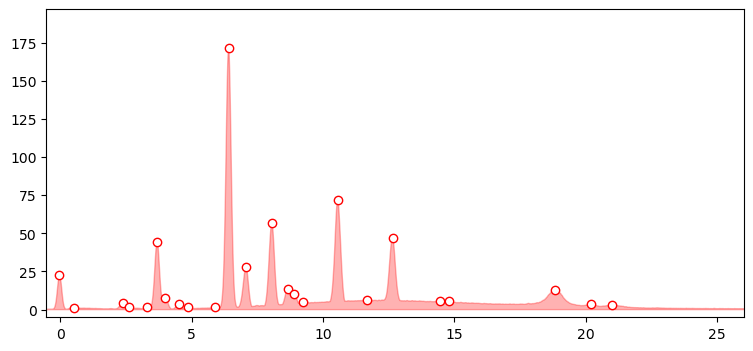

Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 107.78 s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 


Write hotmax spectra, spots and peak indices to datastack file [y/n]?  n


In [ ]:
compute_hotmax_spectra('RP-T-1898-A-3689.datastack')

In further analysis our stored hotmax spectra, spots and peak indexes can now be accessed from file using the `DataStack.read(<datapath>)` and `DataStack.read_list(<datapath>)` methods. 

In [ ]:
#|hide
%matplotlib inline

In [ ]:
from maxrf4u import DataStack 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')

x_keVs = ds.read('maxrf_energies')
hotmax_spectra = ds.read('hotmax_spectra')
hotmax_spots = ds.read('hotmax_spots')
hotmax_peak_idxs_list = ds.read_list('hotmax_peak_idxs_list')

To get an idea, let's plot both the spatial (x, y) locations of the hotmax spots on the image of the drawing, and their corresponding hotmax spectra. 

In [ ]:
#|code-fold: true 
import matplotlib.pyplot as plt 
from maxrf4u.peakmaps import _add_hotlines_ticklabels 

In [ ]:
#|code-fold: true 
 
y, x = hotmax_spots.T

im = ds.read('imvis_reg_highres')
extent = ds.read('imvis_extent')

fig = plt.figure(figsize=[7, 8], constrained_layout=True)
grid = plt.GridSpec(22, 2, figure=fig)

ax = fig.add_subplot(grid[0:22, 0])
ax.imshow(im, extent=extent)
ax.scatter(x, y, alpha=0.4, color='r', marker='s');

ax.set_title('Hotmax spots')

axs = []
for n, spectrum in enumerate(hotmax_spectra): 
    
    ax1 = fig.add_subplot(grid[n, 1])
    axs.append(ax1)
    
    ax1.plot(x_keVs, spectrum)
    
    peak_idxs = hotmax_peak_idxs_list[n]
    ax1.scatter(x_keVs[peak_idxs], spectrum[peak_idxs], alpha=0.4, color='r', marker='s')
    
    ax1.set_xlim([-1, 25])
    ax1.set_yticks([])
    # label 
    ax1.text(-0.015, 0.5, f'{n}', c='C0', ha='right', va='center', transform=ax1.transAxes)
    
axs[0].get_shared_x_axes().join(*axs)

# hack to suppress ticklabels in upper plot 
# https://stackoverflow.com/questions/4209467 
# matplotlib-share-x-axis-but-dont-show-x-axis-tick-labels-for-both-just-one
for ax1 in axs[0:-1]: 
    plt.setp(ax1.get_xticklabels(), visible=False) 
    
axs[0].set_title('Hotmax spectra')
axs[-1].set_xlabel('energy (keV)')


for i, xy in enumerate(zip(x, y)): 
    # hack to avoid overlapping labels 
    xytext = [0, 6]
    if i == 6: 
        xytext = [0, -12]
    if i == 16: 
        xytext = [0, -12]
    ax.annotate(f'[{i}]', xy, xytext=xytext, color='C0', textcoords='offset points', ha='center')
    


..

Now let's pick one of the 22 hotmax spectra and take a closer look. Each hotmax spectrum has one or more peaks (square red marker) that correspond to specific peaks in the the max spectrum envelope. 

In [ ]:
#|code-fold: true 

ds = DataStack('RP-T-1898-A-3689.datastack')

hotmax_spectra = ds.read('hotmax_spectra')

hotmax_peak_idxs_list = ds.read('hotmax_peak_idxs_list')
x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 

n = 12 

spectrum = hotmax_spectra[n]
idxs = hotmax_peak_idxs_list[n] 
peaks_x = x_keVs[idxs]
peaks_y = spectrum[idxs]

fig, ax = plt.subplots(figsize=[7, 3])

ax.plot(x_keVs, spectrum, label=f'hotmax spectrum #{n}')
ax.scatter(peaks_x, peaks_y, edgecolor='r', 
           marker='s', facecolor='w', label=f'hotmax peak(s)')
ax.fill_between(x_keVs, y_max, color='r', alpha=0.2, label='max spectrum')
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Intensity [#counts]')
ax.set_ylim(-1, 1.1*spectrum.max())
ax.set_xlim(-1, 25)
ax.grid()
ax.legend();
plt.tight_layout()

..

The measured spectrum consists of a a slowly varying baseline, the so-called the continuum ridge, with peaks added on top. Some of these peaks are caused by x-ray fluorescence of specific chemical elements or Other peaks are just noise. The difficulty with these kind of spectra is that the noise level varies with the signal according to Poisson statistics. The variance of noise is linearly proportional to the signal level. For this reason, we observe more noise on top of the continuum ridge. 

In order to distinguish significant peaks from noise it is possible to estimate a baseline with a noise envelope for the hotmax spectra with the `compute_hotmax_noise()`function. The algorithm used in estimating the baseline function is the rolling ball filter. In accordance with Poisson statistics, the noise level is estimated as a square root function of the baseline level. 

In [ ]:
from maxrf4u import compute_hotmax_noise

In [ ]:
compute_hotmax_noise('RP-T-1898-A-3689.datastack')

Ready computing 22 noise envelopes.                           

Write hotmax baselines and noiselines to datastack file [y/n]? n


Given the computed noise envelope for each spectrum we are now ready to locate potentially significant peaks with the `compute_subpeaks()` function and save their locations to the datastack file. 

In [ ]:
from maxrf4u import compute_subpeaks

In [ ]:
compute_subpeaks('RP-T-1898-A-3689.datastack');

Write hotmax baselines and noiselines to datastack file [y/n]? n


We can now create a `HotmaxAtlas` object to plot all spectra with their noise envelopes and sub peaks with the `HotmaxAtlas.plot_spectra()` method. 

In [ ]:
from maxrf4u import HotmaxAtlas 

In [ ]:
hma = HotmaxAtlas('RP-T-1898-A-3689.datastack')

#hma.plot_spectra()

Or we can plot a single spectrum with `HotmaxAtlas.plot_spectrum(<nr>)` to inspect a specific hotmax spectrum. 

In [ ]:
hma.plot_spectrum(12);

..

Each specific chemical element present is known to cause a specific peak pattern. Now we need to solve the inverse problem, which I call 'the peak pattern puzzle'. Given a spectrum, which combination of elements is likely to have caused the combination of peaks we find in the spectrum? This is the topic of the next section... 

# FUNCTIONS  

In [ ]:
#|export 

import maxrf4u 
import scipy.signal as ssg 
import numpy as np 
import time 
import matplotlib.pyplot as plt 
from dask.diagnostics import ProgressBar 
import scipy.ndimage.morphology as morph 
import scipy.interpolate as sip 
from IPython.display import SVG 

In [ ]:
#|export 

class HotmaxAtlas(): 
    
    def __init__(self, datastack_file, prominence=0.2): 
        
        # read from datastack file (arrays)
        
        ds = maxrf4u.DataStack(datastack_file)
        
        self.x_keVs = ds.read('maxrf_energies') 
        self.y_max = ds.read('maxrf_maxspectrum') 
        self.hotmax_pixels = ds.read('hotmax_pixels')
        self.hotmax_spectra = ds.read('hotmax_spectra')
        self.baselines = ds.read('hotmax_baselines')
        self.noiselines = ds.read('hotmax_noiselines') 
        
        self.n_spectra = len(self.hotmax_spectra) 
        self.submax_spectrum = np.max(self.hotmax_spectra, axis=0) # core max spectrum
        
        # read from datastack file (ragged lists) 
        
        self.peak_idxs_list = ds.read_list('hotmax_peak_idxs_list')
        self.subpeak_idxs_list = ds.read_list('hotmax_subpeak_idxs_list')  
        
         
    def plot_spectrum(self, n, ax=None, legend=False, headspace=1, footspace=0.1, 
                      hotlines_ticklabels=True, tight_layout=False): 
        
        if ax is None: 

            fig, ax = plt.subplots(figsize=[9, 3])
            
        # NO LONGER 
        #hmp_i = self.hotmax_pixels[n, 2] 
        
        # the hotmax spectrum 
        ax.plot(self.x_keVs, self.hotmax_spectra[n], 
                zorder=-1, label=f'hotmax spectrum #{n}')
        
        # maxspectrum 
        ax.fill_between(self.x_keVs, self.y_max, color='r', alpha=0.15, zorder=8-30, label='max spectrum')
        ax.fill_between(self.x_keVs, self.submax_spectrum, color='r', alpha=0.1)
        
        # noise envelope 
        ax.fill_between(self.x_keVs, self.baselines[n], self.noiselines[n], 
                        color=[0.5, 0.5, 0.9], zorder=10-30, alpha=0.4, label='noise envelope')
        
        # fill subpeaks 
        ax.fill_between(self.x_keVs, self.noiselines[n], self.hotmax_spectra[n], 
                        where=self.hotmax_spectra[n] > self.noiselines[n],
                        color='b', alpha=0.5, zorder=8-30, label='max spectrum')
   
        # NEED DIFFERENT CODE 
        # the hotmax pixel peak (square marker)
        #hmp_x = self.x_keVs[hmp_i]
        #hmp_y = self.hotmax_spectra[n, hmp_i]
        #ax.scatter(hmp_x, hmp_y, marker='s', zorder=1, edgecolor='r', 
        #           facecolor='w', label=f'hotmax peak #{n}')
        
        hmp_x = self.x_keVs[self.peak_idxs_list[n]]
        hmp_y = self.hotmax_spectra[n][self.peak_idxs_list[n]]
        ax.scatter(hmp_x, hmp_y, marker='s', zorder=1, edgecolor='r', 
                   facecolor='w', label=f'hotmax peak #{n}') 

        # submax peaks (round markers)
        peaks_x = self.x_keVs[self.subpeak_idxs_list[n]]
        peaks_y = self.hotmax_spectra[n, self.subpeak_idxs_list[n]]
        ax.scatter(peaks_x, peaks_y, edgecolor='b', alpha=1, zorder=0, facecolor='w')
        
        # annotate submax peaks 
        peak_labels = [f'({i})' for i, _ in enumerate(self.subpeak_idxs_list[n])]
        ann_list = []
        for i, plabel in enumerate(peak_labels):  
            peak_xy = peaks_x[i], peaks_y[i] 
            ann = ax.annotate(plabel, peak_xy, xytext=[0, 10], color='b', 
                              textcoords='offset points', ha='center')
            ann_list.append(ann)
 

        # plot limits 
        ymax = 1.15 * self.hotmax_spectra[n].max() # add space for peak labels 
        ymin = -ymax / 5 
        ax.set_ylim(footspace * ymin, headspace * ymax)
        xlim = self.x_keVs[max(self.hotmax_pixels[:, 2])] + 2
        ax.set_xlim(-1, xlim)
        
        # remove negative yticks from footspace  
        yticks = ax.get_yticks()
        is_positive = yticks >= 0
        ax.set_yticks(yticks[is_positive])
        # again why ?? 
        ax.set_ylim(footspace * ymin, headspace * ymax)
        
        # label 
        ax.text(0.995, 0.98, f'#{n}', c='grey', ha='right', va='top', transform=ax.transAxes)
        
        
        # plot lines in pattern overview for all hotmax peaks  
        lines_x = self.x_keVs[self.hotmax_pixels[:, 2]]
        ax.vlines(lines_x, ymin=0, ymax=2*ymax*headspace, color='r', alpha=0.2, zorder=9-30)
        
        
        # add legend and labels etcetera if standalone 
        if legend:    
            ax.set_xlabel('energy [keV]')
            ax.set_ylabel('Intensity [#counts]')
            ax.legend() 
        
        
        # add hotlines ticklabels 
        if hotlines_ticklabels: 
            x_keVs = self.x_keVs
            hotmax_z = self.hotmax_pixels[:, 2]

            #ax, _ = hma.plot_spectrum(10)
            twax = ax.twiny()
            twax.set_xlim(ax.get_xlim())
            twax.set_xticks(x_keVs[hotmax_z])
            twax.set_xticklabels(range(len(hotmax_z)), fontsize=6, color='r')

            twax.tick_params(color=[1, 0.5, 0.5], pad=0)
        
        if tight_layout: 
            plt.tight_layout()
        
        return ax, ann_list 
    
        
    def plot_spectra(self, svg=True): 
        
        if svg: 
            plt.ioff()
        
        fig, axs = plt.subplots(nrows=self.n_spectra, figsize=[9, self.n_spectra], sharex=True)
        
        axs[0].set_title('hotmax spectra')
        
        xlim = self.x_keVs[max(self.hotmax_pixels[:, 2])] + 2
        
        for n, ax in enumerate(axs): 
            self.plot_spectrum(n, ax=ax, hotlines_ticklabels=False)
            
            # limits 
            ylim = 1.3 * self.hotmax_spectra[n].max()
            ax.set_ylim(-1, ylim)
            ax.set_xlim(-1, xlim)
            #ax.text(0.95, 0.95, f'{n}', ha='right', va='top', transform=ax.transAxes)
        
        ax.set_xlabel('Energy [keV]')
        
        plt.tight_layout() 
        plt.subplots_adjust(hspace=0.1)
        
        
        if svg: 
            plt.savefig('plot.svg') 
            fig.clear()
            plt.ion()
            return SVG('plot.svg')

        
        
def compute_hotmax_spectra(datastack_file, prominence=0.35): 
    '''Collect hotmax pixels and corresponding spectra from *datastack_file*. 
    
    Ask user confirmation for saving result to datastack file. 
    '''
   
    # read max spectrum 
    ds = maxrf4u.DataStack(datastack_file)
    x_keVs = ds.read(ds.MAXRF_ENERGIES)
    y_max = ds.read(ds.MAXRF_MAXSPECTRUM)

    # locate max spectrum peaks in max spectrum 
    peak_indices, _ = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x = x_keVs[peak_indices]
    peaks_y = y_max[peak_indices]
    
    # plot max spectrum with peaks 
    
    plt.close('all')
    plt.ion() # important for updating plots with fig.canvas.draw() 
    
    fig, ax = plt.subplots(figsize=[9, 4])

    fig.canvas.draw()   
    ax.fill_between(x_keVs, y_max, color='r', alpha=0.3)
    ax.scatter(peaks_x, peaks_y, facecolor='w', edgecolor='r')  
    ax.set_xlim(peaks_x[0] - 0.5, peaks_x[-1] + 5) 
    ax.set_ylim(-5, 1.15 * np.max(peaks_y))
    
    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
    

    for i, peak_xy in enumerate(zip(peaks_x, peaks_y)): 
        ax.annotate(f'[{i}]', peak_xy, xytext=[0, 10], color='r', 
                        textcoords='offset points', ha='center')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel('Max spectrum intensity [counts]')
    ax.set_title(f'Found {len(peak_indices)} peaks with prominence > {prominence}')
    ax.grid()

    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
 
    
    # read corresponding channel maps for all max peak indices 
    print('Step 1/3: Reading hot max channel maps...')
    with ProgressBar(): 
        channel_maps = ds.maxrf_cube[:,:,peak_indices].compute() 

    channel_maps = channel_maps.transpose([2, 0, 1])

    # locate hot max pixels in channel maps 
    print('Step 2/3: Locating hot max pixels...')
    hot_pixels = []
    for k, c_map in enumerate(channel_maps): 
        hot_i, hot_j = np.argwhere(c_map == peaks_y[k]).flatten()
        hot_pixels.append([hot_i, hot_j, peak_indices[k]]) # xy

    hot_pixels = np.array(hot_pixels)  
    
    # need to deduplicate identical spectra (i.e. superimposed hotmax pixels)
    
    hotmax_spots, hotmax_peak_idxs_list = _group_superimposed(hot_pixels)
    

    # read spectrum for each hot max pixel  
    hotmax_spectra = [] 
    for n, [i, j] in enumerate(hotmax_spots):
        print(f'Step 3/3: Reading hot max spectrum {n}/{len(hotmax_spots) - 1}...', end='\r')
        spectrum = ds.maxrf_cube[i,j,:].compute()
        hotmax_spectra.append(spectrum)
        
        ax.plot(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.5) 
        ax.fill_between(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.3) 
        
        # DEPRECIATING MASK, INSTEAD USING RAGGED LIST  
        
        #x = x_keVs[hotmax_mask[n]]
        #y = spectrum[hotmax_mask[n]] 
        
        x = x_keVs[hotmax_peak_idxs_list[n]]
        y = spectrum[hotmax_peak_idxs_list[n]]
        ax.scatter(x, y, facecolor='b', edgecolor='r') 

        # force updating plot 
        plt.pause(0.2) 
        fig.canvas.draw()
        fig.canvas.flush_events()
        
    print(f'Step 3/3: Ready with reading hot max spectra. ')

    hotmax_spectra = np.array(hotmax_spectra)   
    
    # user input           
    write = input('Write hotmax spectra, spots and peak indices to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(hotmax_spectra, ds.HOTMAX_SPECTRA, ds.datastack_file)
        maxrf4u.append(hotmax_spots, 'hotmax_spots', ds.datastack_file) 
        maxrf4u.append_list(hotmax_peak_idxs_list, 'hotmax_peak_idxs_list', ds.datastack_file) 

        print(f'\nSaved hotmax data to: {ds.datastack_file}')
        
    # force updating plot 
    plt.pause(0.3) 
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    return  



def compute_hotmax_noise(datastack_file, radius=200, alpha=0.6, beta=0.1): 
    '''Utility function to get baselines and noiselines from hotmax spectra in *datastack_file*.  
    
    Use once to compute base noise envelopes. Ask user confirmation for saving result to datastack file. '''
    
    ds = maxrf4u.DataStack(datastack_file)
    
    x_keVs = ds.read(ds.MAXRF_ENERGIES)
    hotmax_spectra = ds.read(ds.HOTMAX_SPECTRA)
        
    baseline_spectra = []  
    noiseline_spectra = []
    
    for i, spectrum in enumerate(hotmax_spectra): 
        
        print(f'Computing noise envelope for hotmax spectrum {i+1}/{len(hotmax_spectra)}...', end='\r')
        
        baseline, lowest_indices = _baseline(x_keVs, spectrum, radius=radius, return_indices=True)
        baseline_spectra.append(baseline)
        
        noiseline = _noiseline(baseline, alpha=alpha, beta=beta) 
        noiseline_spectra.append(noiseline) 
        
    print(f'Ready computing {len(hotmax_spectra)} noise envelopes.                           \n')
    
    # user input           
    write = input('Write hotmax baselines and noiselines to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(baseline_spectra, ds.HOTMAX_BASELINES, ds.datastack_file)
        maxrf4u.append(noiseline_spectra, ds.HOTMAX_NOISELINES, ds.datastack_file) 

        print(f'\nSaved hotmax noise data to: {ds.datastack_file}')
    
    return 

def compute_subpeaks(datastack_file, prominence=0.2): 
    '''Find subpeaks in hotmax spectrum that exceed the noise envelope.
    
    Writes result to datas
    
    Returns: list of hotmax sub peak indices'''
    
    subpeak_idxs_list = []
    
    ds = maxrf4u.DataStack(datastack_file)
    hotmax_spectra = ds.read('hotmax_spectra')
    noiselines = ds.read('hotmax_noiselines')
    
    for y_hot, noiseline in zip(hotmax_spectra, noiselines): 
    
        # clip 
        above_noise = y_hot - noiseline 
        above_noise[above_noise < 0] = 0 

        peak_idxs, _ = ssg.find_peaks(above_noise, prominence=prominence) 

        # sort by peak height 
        peak_heights = above_noise[peak_idxs]
        peak_order = np.argsort(peak_heights)[::-1] 
        peak_idxs = peak_idxs[peak_order] 

        # hack to correct peak positions due to baseline tilting 
        peak_idxs = _untilt(peak_idxs, y_hot, delta=5) 
        
        # append 
        subpeak_idxs_list.append(peak_idxs)
         
    # user input           
    write = input('Write hotmax baselines and noiselines to datastack file [y/n]? ')    
    
    if write == 'y': 
         
        datapath = 'hotmax_subpeak_idxs_list'
        maxrf4u.append_list(subpeak_idxs_list, datapath, datastack_file)       
        print(f'\nSaved hotmax subpeak indexes list to: {datastack_file}')
        
    
    return subpeak_idxs_list 



def _baseline(x_keVs, spectrum, radius=200, return_indices=False): 
    '''Calculate rolling ball baseline for *spectrum*.  
    
    Uses Euclidian distance map to select only the lowest surges that touch the rolling ball.'''

    spectrum_norm = spectrum / spectrum.max()
    
    w = len(spectrum) 
    h = w // 2

    # initialize ramp with normalized spectrum in top half  
    ramp = np.ones([h, w]) * np.linspace(1, -1, h)[:, None]
    
    # create boolean mask from spectrum 
    spectrum_mask = ramp < spectrum_norm 
    
    # create distance map for spectrum mask. 
    dist_map, index_images = morph.distance_transform_edt(spectrum_mask, return_indices=True)

    # we only need the second (x-axis) channel index image
    _, index_img = index_images 

    # roll the ball 
    ball_mask = dist_map < radius 
    ball_profile = ball_mask.sum(axis=0) 

    # get touching surges indices 
    lowest_indices = list(set(index_img[ball_profile, range(w)]))
    
    # create linear interpolation between the selected lowest surges (valleys)
    # added fill_value=0 to avoid Nan's if extrapolating loose ends to avoid Nan's in baseline 
    interpolation = sip.interp1d(x_keVs[lowest_indices], spectrum[lowest_indices], bounds_error=False, fill_value=0)
    baseline = interpolation(x_keVs) 
    
    # valley indices 
    if return_indices: 
        return baseline, lowest_indices 
    
    return baseline 

def _noiseline(baseline, alpha=0.6, beta=0.1): 
    '''Estimate Poisson noise line from *baseline*. '''
    
    noiseline = baseline + alpha * np.sqrt(baseline + beta**2)
    
    return noiseline 



def _untilt(peak_idxs, y_hot, delta=5): 
    '''Adjust peak index positions to nearest true maxima.'''
    
    local_maxima = ssg.argrelextrema(y_hot, np.greater)[0] 
    
    new_peak_idxs = []

    for i in peak_idxs: 
    
        if i in list(local_maxima): 
            new_peak_idxs.append(i)

        else: 
            nearest = np.argmin((local_maxima - i)**2)
            i_new = local_maxima[nearest] 
            new_peak_idxs.append(i_new) 
            
    # check  
    for i in new_peak_idxs: 
        assert i in list(local_maxima), 'Peak adjustment error'
            
    return new_peak_idxs 


def _group_superimposed(hotmax_pixels): 
    '''Group superimposed `hotmax_pixels`. 
    
    Returns: hotmax_spots, hotmax_peak_idxs_list '''
    
    hotspots = hotmax_pixels[:,:2] 
    unique_hotspots = np.unique(hotspots, axis=0)
    
    # create ragged sorted list of indices 
    indices_list = [] 

    for u in unique_hotspots: 
        is_spot = np.all(hotspots == u, axis=1)
        indices = np.arange(len(hotspots))[is_spot].tolist()
        indices_list.append(indices)
        
    first_indices = [idxs[0] for idxs in indices_list]

    # sort spectrum indices according to lowest energy hotmax peak 
    sorting = np.argsort(first_indices)
    ragged_idxs = [indices_list[s] for s in sorting] 
    
    # create corresponding ragged list of peak channel indices 
    hotmax_peak_idxs_list = [list(hotmax_pixels[:,2][idxs]) for idxs in ragged_idxs] 
    
    # create corresponding list hotspots 
    hotmax_spots = np.array([hotmax_pixels[idxs[0]][0:2] for idxs in ragged_idxs])
    
    # DEPRECIATING BOOLEAN MASK: WILL USE append_list() INSTEAD  
    ## creat mask
    #n_hotspots = len(hotmax_spots)
    #shape = [n_hotspots, n_channels]
    #hotmax_mask = np.zeros(shape, dtype=bool)
    #
    #for i, idxs in enumerate(ragged_indices): 
    #    peak_idxs = hotmax_pixels[idxs][:, 2]
    #    hotmax_mask[i][peak_idxs] = True               
    #
    #return hotmax_spots, hotmax_mask 
    
    return hotmax_spots, hotmax_peak_idxs_list 
    